### Read files

In [1]:
import glob, re
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn import *

data = {
    #visitors
    'tra': pd.read_csv('./input/air_visit_data.csv',parse_dates=["visit_date"]),
    #reservations
    'ar': pd.read_csv('./input/air_reserve.csv',parse_dates=["visit_datetime","reserve_datetime"]),
    'hr': pd.read_csv('./input/hpg_reserve.csv',parse_dates=["visit_datetime","reserve_datetime"]),
    #store info
    'as': pd.read_csv('./input/air_store_info.csv'),
    'hs': pd.read_csv('./input/hpg_store_info.csv'),
    #air<->hpg
    'id': pd.read_csv('./input/store_id_relation.csv'),
    #days
    'hol': pd.read_csv('./input/date_info.csv',parse_dates=["calendar_date"]), #.rename(columns={'calendar_date':'visit_date'})
    #
    'tes': pd.read_csv('./input/sample_submission.csv'),
    }

data["tra"]["visitors"]=np.log1p(data["tra"]["visitors"])
data["tra"]["month"]=data["tra"].visit_date.map(lambda x: x.month)
data["tra"]["month"]=data["tra"]["month"].astype('category')
print(len(data["tra"]))

/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions a

252108


In [2]:
def RMSLE(y, pred):
    return metrics.mean_squared_error(np.log(y+1), np.log(pred+1))**0.5
def RMSE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

### Some data categorizing to reduce space

In [3]:
import sys
data["tra"]["air_store_id"]=data["tra"]["air_store_id"].astype('category')
total=0
for k,v in data.items():
    size_k=sys.getsizeof(data[k])/1024/1024
    total+=size_k
    print(k,size_k)
print("total",total)

hr 192.67313385009766
tra 4.629216194152832
id 0.022129058837890625
hol 0.039612770080566406
ar 8.898050308227539
hs 1.3301172256469727
as 0.23502159118652344
tes 2.9315261840820312
total 210.758807182312


In [4]:
data["tra"]["air_store_id"]=data["tra"]["air_store_id"].astype('category')
data["as"]["air_store_id"]=data["as"]["air_store_id"].astype('category')
data["as"]["air_genre_name"]=data["as"]["air_genre_name"].astype('category')
data["as"]["air_area_name"]=data["as"]["air_area_name"].astype('category')
data["hs"]["hpg_store_id"]=data["hs"]["hpg_store_id"].astype('category')
data["hs"]["hpg_genre_name"]=data["hs"]["hpg_genre_name"].astype('category')
data["hs"]["hpg_area_name"]=data["hs"]["hpg_area_name"].astype('category')
data["ar"]["air_store_id"]=data["ar"]["air_store_id"].astype('category')
data["hr"]["hpg_store_id"]=data["hr"]["hpg_store_id"].astype('category')
data["id"]["hpg_store_id"]=data["id"]["hpg_store_id"].astype('category')
data["id"]["air_store_id"]=data["id"]["air_store_id"].astype('category')
data["hol"]["day_of_week"]=data["hol"]["day_of_week"].astype('category')
data["hol"]["holiday_flg"]=data["hol"]["holiday_flg"].astype('category')

In [5]:
total=0
for k,v in data.items():
    size_k=sys.getsizeof(data[k])/1024/1024
    total+=size_k
    print(k,size_k)
print("total",total)

hr 50.57759189605713
tra 4.629216194152832
id 0.022701263427734375
hol 0.005473136901855469
ar 2.313718795776367
hs 0.45134544372558594
as 0.09117889404296875
tes 2.9315261840820312
total 61.022751808166504


### test

In [6]:
data["tes"][["store_id","time"]]=data["tes"]["id"].str.split("_2017",expand=True)
data["tes"]["time"]="2017"+data["tes"]["time"]
from dateutil import parser
data["tes"]["time"] = pd.to_datetime(data["tes"]["time"])
#data["tes"]["kind"]=data["tes"]["id"].str.split("_",expand=True)[0] #they are all air type

In [7]:
print(data["tes"].dtypes)
#data["tes"].head(5)

id                  object
visitors             int64
store_id            object
time        datetime64[ns]
dtype: object


I add the test dates/stores to the train df

In [8]:
print(len(data["tra"]))

252108


In [9]:
data["tra"]["time_numeric"]=pd.to_numeric(data["tra"].visit_date-data["tra"].visit_date.min())/1e12
data["tra"]["time_numeric"].fillna(0,inplace=True)
data["tra"]["weights"]=np.exp(data["tra"]["time_numeric"]/data["tra"]["time_numeric"].max())
data["tra"].head()

,air_store_id,visit_date,visitors,month,time_numeric,weights
0,air_ba937bf13d40fb24,2016-01-13,3.258097,1,1036.8,1.025476
1,air_ba937bf13d40fb24,2016-01-14,3.496508,1,1123.2,1.027628
2,air_ba937bf13d40fb24,2016-01-15,3.401197,1,1209.6,1.029785
3,air_ba937bf13d40fb24,2016-01-16,3.135494,1,1296.0,1.031946
4,air_ba937bf13d40fb24,2016-01-18,1.945910,1,1468.8,1.036282


In [10]:

test_dates=data["tes"]["time"].unique()
test_stores=data["tes"]["store_id"].unique()

days = pd.DataFrame({'visit_date':test_dates})
stores = pd.DataFrame({'air_store_id':test_stores})
stores['key'] = 0
days['key'] = 0
days_and_stores = days.merge(stores, how='left', on = 'key')
days_and_stores.drop('key',1, inplace=True)
days_and_stores

data["tra_test"]=data["tra"].append(days_and_stores)




In [11]:
print(len(days_and_stores))
print(len(data["tra"]))
print(len(data["tra_test"]))
#data["tra"]

32019
252108
284127


### Analysis

Join dataframes

- train + store info

In [12]:
data["tra_as"]=data["tra"].merge(data["as"],on="air_store_id")
data["tra_as"].head()

,air_store_id,visit_date,visitors,month,time_numeric,weights,air_genre_name,air_area_name,latitude,longitude
0,air_ba937bf13d40fb24,2016-01-13,3.258097,1,1036.8,1.025476,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
1,air_ba937bf13d40fb24,2016-01-14,3.496508,1,1123.2,1.027628,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_ba937bf13d40fb24,2016-01-15,3.401197,1,1209.6,1.029785,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
3,air_ba937bf13d40fb24,2016-01-16,3.135494,1,1296.0,1.031946,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
4,air_ba937bf13d40fb24,2016-01-18,1.945910,1,1468.8,1.036282,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [13]:
genre_mean_0=pd.DataFrame()
#genre_mean_0["genre_mean"]=data["tra_as"].groupby("air_genre_name").visitors.mean()
#genre_mean_0["genre_median"]=data["tra_as"].groupby("air_genre_name").visitors.median()
#genre_mean_0["genre_min"]=data["tra_as"].groupby("air_genre_name").visitors.min()
#genre_mean_0["genre_max"]=data["tra_as"].groupby("air_genre_name").visitors.max()
#genre_mean_0["genre_std"]=data["tra_as"].groupby("air_genre_name").visitors.std()
genre_mean_0["genre_wht_mean"]=data["tra_as"].groupby("air_genre_name").apply(lambda x: np.average(x['visitors'], weights=x['weights']))
#genre_mean_0["genre_wht_mean"]=data["tra_as"].groupby("air_genre_name").apply(lambda x: np.average(x['visitors']))

genre_mean_0.reset_index(inplace=True)
genre_mean_0.head()

,air_genre_name,genre_wht_mean
0,Asian,3.512235
1,Bar/Cocktail,2.348968
2,Cafe/Sweets,2.897400
3,Creative cuisine,2.962171
4,Dining bar,2.642158


In [14]:
area_mean_0=pd.DataFrame()
#area_mean_0["area_mean"]=data["tra_as"].groupby("air_area_name").visitors.mean()
#area_mean_0["area_median"]=data["tra_as"].groupby("air_area_name").visitors.median()
#area_mean_0["area_min"]=data["tra_as"].groupby("air_area_name").visitors.min()
#area_mean_0["area_max"]=data["tra_as"].groupby("air_area_name").visitors.max()
#area_mean_0["area_std"]=data["tra_as"].groupby("air_area_name").visitors.std()
area_mean_0["area_wht_mean"]=data["tra_as"].groupby("air_area_name").apply(lambda x: np.average(x['visitors'], weights=x['weights']))
area_mean_0.reset_index(inplace=True)
area_mean_0.head()

,air_area_name,area_wht_mean
0,Fukuoka-ken Fukuoka-shi Daimyō,2.771733
1,Fukuoka-ken Fukuoka-shi Hakata Ekimae,2.857302
2,Fukuoka-ken Fukuoka-shi Imaizumi,2.668836
3,Fukuoka-ken Fukuoka-shi Momochi,2.655420
4,Fukuoka-ken Fukuoka-shi Shiobaru,2.557863


- train + day + store info

In [15]:
data["tra_as_hol_0"]=data["tra"].merge(data["as"],on="air_store_id").merge(data["hol"],left_on="visit_date",right_on="calendar_date").\
                    drop("calendar_date",axis=1)
data["tra_as_hol_0"].head()

,air_store_id,visit_date,visitors,month,time_numeric,weights,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,3.258097,1,1036.8,1.025476,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Wednesday,0
1,air_25e9888d30b386df,2016-01-13,3.091042,1,1036.8,1.025476,Izakaya,Tōkyō-to Shinagawa-ku Higashigotanda,35.626568,139.725858,Wednesday,0
2,air_fd6aac1043520e83,2016-01-13,3.713572,1,1036.8,1.025476,Izakaya,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Wednesday,0
3,air_64d4491ad8cdb1c6,2016-01-13,1.791759,1,1036.8,1.025476,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Wednesday,0
4,air_ee3a01f0c71a769f,2016-01-13,2.944439,1,1036.8,1.025476,Cafe/Sweets,Shizuoka-ken Hamamatsu-shi Motoshirochō,34.710895,137.725940,Wednesday,0


In [16]:
genre_mean_dow=pd.DataFrame()
#genre_mean_dow["genre_mean_dow"]=data["tra_as_hol_0"].groupby(["air_genre_name","day_of_week"]).visitors.mean()
#genre_mean_dow["genre_median_dow"]=data["tra_as_hol_0"].groupby(["air_genre_name","day_of_week"]).visitors.median()
#genre_mean_dow["genre_min_dow"]=data["tra_as_hol_0"].groupby(["air_genre_name","day_of_week"]).visitors.min()
#genre_mean_dow["genre_max_dow"]=data["tra_as_hol_0"].groupby(["air_genre_name","day_of_week"]).visitors.max()
#genre_mean_dow["genre_std_dow"]=data["tra_as_hol_0"].groupby(["air_genre_name","day_of_week"]).visitors.std()
genre_mean_dow["genre_wht_mean_dow"]=data["tra_as_hol_0"].groupby(["air_genre_name","day_of_week"]).apply(lambda x: np.average(x['visitors'], weights=x['weights']))

genre_mean_dow.reset_index(inplace=True)
genre_mean_dow.head()

,air_genre_name,day_of_week,genre_wht_mean_dow
0,Asian,Friday,3.581434
1,Asian,Monday,3.383633
2,Asian,Saturday,3.678748
3,Asian,Sunday,3.721482
4,Asian,Thursday,3.337306


In [17]:
genre_mean_hol=pd.DataFrame()
#genre_mean_hol["genre_mean_hol"]=data["tra_as_hol_0"].groupby(["air_genre_name","holiday_flg"]).visitors.mean()
#genre_mean_hol["genre_median_hol"]=data["tra_as_hol_0"].groupby(["air_genre_name","holiday_flg"]).visitors.median()
#genre_mean_hol["genre_min_hol"]=data["tra_as_hol_0"].groupby(["air_genre_name","holiday_flg"]).visitors.min()
#genre_mean_hol["genre_max_hol"]=data["tra_as_hol_0"].groupby(["air_genre_name","holiday_flg"]).visitors.max()
#genre_mean_hol["genre_std_hol"]=data["tra_as_hol_0"].groupby(["air_genre_name","holiday_flg"]).visitors.std()
genre_mean_hol["genre_wht_mean_hol"]=data["tra_as_hol_0"].groupby(["air_genre_name","holiday_flg"]).apply(lambda x: np.average(x['visitors'], weights=x['weights']))


genre_mean_hol.reset_index(inplace=True)
genre_mean_hol.head()

,air_genre_name,holiday_flg,genre_wht_mean_hol
0,Asian,0,3.512910
1,Asian,1,3.499244
2,Bar/Cocktail,0,2.338968
3,Bar/Cocktail,1,2.531758
4,Cafe/Sweets,0,2.889065


In [18]:
area_mean_dow=pd.DataFrame()
#area_mean_dow["area_mean_dow"]=data["tra_as_hol_0"].groupby(["air_area_name","day_of_week"]).visitors.mean()
#area_mean_dow["area_median_dow"]=data["tra_as_hol_0"].groupby(["air_area_name","day_of_week"]).visitors.median()
#area_mean_dow["area_min_dow"]=data["tra_as_hol_0"].groupby(["air_area_name","day_of_week"]).visitors.min()
#area_mean_dow["area_max_dow"]=data["tra_as_hol_0"].groupby(["air_area_name","day_of_week"]).visitors.max()
#area_mean_dow["area_std_dow"]=data["tra_as_hol_0"].groupby(["air_area_name","day_of_week"]).visitors.std()
area_mean_dow["area_wht_mean_dow"]=data["tra_as_hol_0"].groupby(["air_area_name","day_of_week"]).apply(lambda x: np.average(x['visitors'], weights=x['weights']))

area_mean_dow.reset_index(inplace=True)
area_mean_dow.head()

,air_area_name,day_of_week,area_wht_mean_dow
0,Fukuoka-ken Fukuoka-shi Daimyō,Friday,2.847578
1,Fukuoka-ken Fukuoka-shi Daimyō,Monday,2.636426
2,Fukuoka-ken Fukuoka-shi Daimyō,Saturday,3.049685
3,Fukuoka-ken Fukuoka-shi Daimyō,Sunday,2.881511
4,Fukuoka-ken Fukuoka-shi Daimyō,Thursday,2.677424


In [19]:
area_mean_hol=pd.DataFrame()
#area_mean_hol["area_mean_hol"]=data["tra_as_hol_0"].groupby(["air_area_name","holiday_flg"]).visitors.mean()
#area_mean_hol["area_median_hol"]=data["tra_as_hol_0"].groupby(["air_area_name","holiday_flg"]).visitors.median()
#area_mean_hol["area_min_hol"]=data["tra_as_hol_0"].groupby(["air_area_name","holiday_flg"]).visitors.min()
#area_mean_hol["area_max_hol"]=data["tra_as_hol_0"].groupby(["air_area_name","holiday_flg"]).visitors.max()
#area_mean_hol["area_std_hol"]=data["tra_as_hol_0"].groupby(["air_area_name","holiday_flg"]).visitors.std()
area_mean_hol["area_wht_mean_hol"]=data["tra_as_hol_0"].groupby(["air_area_name","holiday_flg"]).apply(lambda x: np.average(x['visitors'], weights=x['weights']))

area_mean_hol.reset_index(inplace=True)
area_mean_hol.head()

,air_area_name,holiday_flg,area_wht_mean_hol
0,Fukuoka-ken Fukuoka-shi Daimyō,0,2.764310
1,Fukuoka-ken Fukuoka-shi Daimyō,1,2.904366
2,Fukuoka-ken Fukuoka-shi Hakata Ekimae,0,2.852027
3,Fukuoka-ken Fukuoka-shi Hakata Ekimae,1,2.953138
4,Fukuoka-ken Fukuoka-shi Imaizumi,0,2.670225


- train + day info

In [28]:
data["tra_hol"]=data["tra"].merge(data["hol"],left_on="visit_date",right_on="calendar_date").\
            drop("calendar_date",axis=1)
data["tra_hol"]["month"]=data["tra_hol"].visit_date.map(lambda x: x.month)
data["tra_hol"]["month"]=data["tra_hol"]["month"].astype('category')
data["tra_hol"].head()

,air_store_id,visit_date,visitors,month,time_numeric,weights,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,3.258097,1,1036.8,1.025476,Wednesday,0
1,air_25e9888d30b386df,2016-01-13,3.091042,1,1036.8,1.025476,Wednesday,0
2,air_fd6aac1043520e83,2016-01-13,3.713572,1,1036.8,1.025476,Wednesday,0
3,air_64d4491ad8cdb1c6,2016-01-13,1.791759,1,1036.8,1.025476,Wednesday,0
4,air_ee3a01f0c71a769f,2016-01-13,2.944439,1,1036.8,1.025476,Wednesday,0


In [29]:
store_mean_0=pd.DataFrame()
#store_mean_0["store_mean"]=data["tra"].groupby("air_store_id").visitors.mean()
#store_mean_0["store_median"]=data["tra"].groupby("air_store_id").visitors.median()
#store_mean_0["store_min"]=data["tra"].groupby("air_store_id").visitors.min()
#store_mean_0["store_max"]=data["tra"].groupby("air_store_id").visitors.max()
#store_mean_0["store_std"]=data["tra"].groupby("air_store_id").visitors.std()
store_mean_0["store_wht_mean"]=data["tra"].groupby("air_store_id").apply(lambda x: np.average(x['visitors'], weights=x['weights']))

store_mean_0.reset_index(inplace=True)
store_mean_0.head()


,air_store_id,store_wht_mean
0,air_00a91d42b08b08d9,3.181034
1,air_0164b9927d20bcc3,2.110157
2,air_0241aa3964b7f861,2.217256
3,air_0328696196e46f18,1.970034
4,air_034a3d5b40d5b1b1,2.512139


In [30]:
store_mean_dow=pd.DataFrame()
#store_mean_dow["store_dow_mdn"]=data["tra_hol"].groupby(["air_store_id","day_of_week"]).visitors.median() #.reset_index()
#store_mean_dow["store_dow_mean"]=data["tra_hol"].groupby(["air_store_id","day_of_week"]).visitors.mean() #.reset_index()
#store_mean_dow["store_dow_min"]=data["tra_hol"].groupby(["air_store_id","day_of_week"]).visitors.min() #.reset_index()
#store_mean_dow["store_dow_max"]=data["tra_hol"].groupby(["air_store_id","day_of_week"]).visitors.max() #.reset_index()
#store_mean_dow["store_dow_std"]=data["tra_hol"].groupby(["air_store_id","day_of_week"]).visitors.std() #.reset_index()
store_mean_dow["store_wht_mean_dow"]=data["tra_hol"].groupby(["air_store_id","day_of_week"]).apply(lambda x: np.average(x['visitors'], weights=x['weights']))
store_mean_dow["store_wht_mean_dow"].fillna(store_mean_0["store_wht_mean"],inplace=True)
#store_mean_dow["store_dow_mdn"].fillna(store_mean_0["store_median"],inplace=True)
#store_mean_dow["store_dow_mean"].fillna(store_mean_0["store_mean"],inplace=True)
#store_mean_dow["store_dow_min"].fillna(store_mean_0["store_min"],inplace=True)
#store_mean_dow["store_dow_max"].fillna(store_mean_0["store_max"],inplace=True)
#store_mean_dow["store_dow_std"].fillna(store_mean_0["store_std"],inplace=True)
#store_mean_dow.fillna(0,inplace=True)
#store_mean_dow=store_mean_dow.drop("visitors",axis=1)
store_mean_dow=store_mean_dow.reset_index() #unstack(level=1)
store_mean_dow.head()

,air_store_id,day_of_week,store_wht_mean_dow
0,air_00a91d42b08b08d9,Friday,3.591833
1,air_00a91d42b08b08d9,Monday,3.081793
2,air_00a91d42b08b08d9,Saturday,2.518185
3,air_00a91d42b08b08d9,Sunday,1.098612
4,air_00a91d42b08b08d9,Thursday,3.412108


In [23]:
store_mean_dow_hol=pd.DataFrame()
#store_mean_dow_hol["store_dow_hol_mdn"]=data["tra_hol"].groupby(["air_store_id","day_of_week",'holiday_flg']).visitors.median() #.reset_index()
#store_mean_dow_hol["store_dow_hol_mean"]=data["tra_hol"].groupby(["air_store_id","day_of_week",'holiday_flg']).visitors.mean() #.reset_index()
#store_mean_dow_hol["store_dow_hol_min"]=data["tra_hol"].groupby(["air_store_id","day_of_week",'holiday_flg']).visitors.min() #.reset_index()
#store_mean_dow_hol["store_dow_hol_max"]=data["tra_hol"].groupby(["air_store_id","day_of_week",'holiday_flg']).visitors.max() #.reset_index()
#store_mean_dow_hol["store_dow_hol_std"]=data["tra_hol"].groupby(["air_store_id","day_of_week",'holiday_flg']).visitors.std() #.reset_index()

store_mean_dow_hol["store_wht_mean_dow_hol"]=data["tra_hol"].groupby(["air_store_id","day_of_week",'holiday_flg']).apply(lambda x: np.average(x['visitors'], weights=x['weights']))
store_mean_dow_hol["store_wht_mean_dow_hol"].fillna(store_mean_dow["store_wht_mean_dow"],inplace=True)

#store_mean_dow_hol["store_dow_hol_mdn"].fillna(store_mean_dow["store_dow_mdn"],inplace=True)
#store_mean_dow_hol["store_dow_hol_mean"].fillna(store_mean_dow["store_dow_mean"],inplace=True)
#store_mean_dow_hol["store_dow_hol_min"].fillna(store_mean_dow["store_dow_min"],inplace=True)
#store_mean_dow_hol["store_dow_hol_max"].fillna(store_mean_dow["store_dow_max"],inplace=True)
#store_mean_dow_hol["store_dow_hol_std"].fillna(store_mean_dow["store_dow_std"],inplace=True)
store_mean_dow_hol=store_mean_dow_hol.fillna(0)
#store_mean_dow=store_mean_dow.drop("visitors",axis=1)
store_mean_dow_hol=store_mean_dow_hol.reset_index() #unstack(level=1)
store_mean_dow_hol.head()

,air_store_id,day_of_week,holiday_flg,store_wht_mean_dow_hol
0,air_00a91d42b08b08d9,Friday,0,3.591833
1,air_00a91d42b08b08d9,Monday,0,3.081579
2,air_00a91d42b08b08d9,Monday,1,3.091042
3,air_00a91d42b08b08d9,Saturday,0,2.518185
4,air_00a91d42b08b08d9,Sunday,0,1.098612


- train +store info + store mean + day info

In [41]:
final_df= data["tra_test"].merge(data["hol"],left_on="visit_date",right_on="calendar_date").\
                    drop("calendar_date",axis=1).\
                    merge(store_mean_dow,on=["air_store_id","day_of_week"]).\
                    merge(store_mean_dow_hol,on=["air_store_id","day_of_week",'holiday_flg']).\
                    merge(data["as"],on=["air_store_id"]).\
                    merge(store_mean_0,on=["air_store_id"]) .\
                    merge(area_mean_0,on=["air_area_name"]).\
                    merge(area_mean_dow,on=["air_area_name","day_of_week"]) .\
                    merge(area_mean_hol,on=["air_area_name","holiday_flg"]) .\
                    merge(genre_mean_hol,on=["air_genre_name","holiday_flg"]).\
                    merge(genre_mean_dow,on=["air_genre_name","day_of_week"]).\
                    merge(genre_mean_0,on=["air_genre_name"])
final_df["month"]=final_df.visit_date.map(lambda x: x.month)
final_df["month"]=final_df["month"].astype('category')           

final_df.head().T



,0,1,2,3,4
air_store_id,air_ba937bf13d40fb24,air_ba937bf13d40fb24,air_ba937bf13d40fb24,air_ba937bf13d40fb24,air_ba937bf13d40fb24
month,1,1,1,2,2
time_numeric,1036.8,1641.6,2246.4,2851.2,3456
visit_date,2016-01-13 00:00:00,2016-01-20 00:00:00,2016-01-27 00:00:00,2016-02-03 00:00:00,2016-02-10 00:00:00
visitors,3.2581,3.46574,3.21888,2.94444,3.49651
weights,1.02548,1.04064,1.05602,1.07163,1.08747
day_of_week,Wednesday,Wednesday,Wednesday,Wednesday,Wednesday
holiday_flg,0,0,0,0,0
store_wht_mean_dow,3.09737,3.09737,3.09737,3.09737,3.09737
store_wht_mean_dow_hol,3.11376,3.11376,3.11376,3.11376,3.11376


One-hot encoding for day of week, holiday, month, genre, area

In [42]:
final_df["month"]=final_df["month"].astype('category')
#data["tra_as_hol"].dtypes
cols_to_enc=["month","day_of_week","air_genre_name", 'air_area_name']
dummies=pd.get_dummies(final_df[cols_to_enc])
#data["tra_as_hol"].join(dummies)

enc=final_df.join(dummies)
enc=final_df

enc=enc.drop(cols_to_enc,axis=1).drop(["latitude","longitude"],axis=1)
enc.head()
#for c in enc.columns: print(c)
print(len(enc.columns))
#print(enc.columns)



15


Binary encoder

In [43]:
def f64_to_32(df):
    float_cols=df.select_dtypes(include=["float64"]).columns
    int_cols=df.select_dtypes(include=["int64"]).columns
    for fc in float_cols:
        print(fc)
        df[fc]=df[fc].astype("float32")
    for ic in int_cols:
        print(ic)
        df[ic]=df[ic].astype("int32")
 


In [44]:
final_df.month.isnull().any()

False

In [45]:
import category_encoders as ce
encoder = ce.BinaryEncoder(cols=cols_to_enc)
enc2=encoder.fit_transform(final_df)

print(sys.getsizeof(enc2)/1024/1024)
f64_to_32(enc2)
print(sys.getsizeof(enc2)/1024/1024)

96.4872179031372
time_numeric
visitors
weights
store_wht_mean_dow
store_wht_mean_dow_hol
latitude
longitude
store_wht_mean
area_wht_mean
area_wht_mean_dow
area_wht_mean_hol
genre_wht_mean_hol
genre_wht_mean_dow
genre_wht_mean
month_0
month_1
month_2
month_3
day_of_week_0
day_of_week_1
day_of_week_2
air_genre_name_0
air_genre_name_1
air_genre_name_2
air_genre_name_3
air_area_name_0
air_area_name_1
air_area_name_2
air_area_name_3
air_area_name_4
air_area_name_5
air_area_name_6
holiday_flg
60.811280250549316


Divide train-test before-after

In [46]:
cut_date='2017-3-15'

def train_test_eval(df,cut_date):
    df_train=df[df.visitors.notnull()][df["visit_date"]<cut_date]        #train
    df_test= df[df.visitors.notnull()][df["visit_date"]>= cut_date]      #test (I have data to check)
    df_eval= df[df.visitors.isnull()]                                   #eval (for submission only, no data to check)
    return(df_train,df_test,df_eval)
    
df_train,df_test,df_eval=train_test_eval(enc,cut_date)

/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


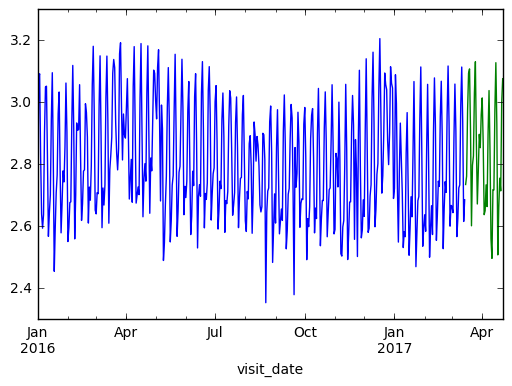

In [47]:
%matplotlib inline
df_train.groupby("visit_date")["visitors"].mean().plot()
df_test.groupby("visit_date")["visitors"].mean().plot()

In [48]:
print(
len(final_df["air_area_name"].unique()),
len(final_df["longitude"].unique()),
len(final_df["latitude"].unique()),
)
print(
len(final_df.groupby(['latitude', 'longitude']).size()),
len(final_df.groupby(["air_area_name",'latitude', 'longitude']).size())
)

103 108 108
108 108


For each store I use mean, min, max, std, area, genre, day and holiday as predictors

In [49]:
df_train.head()

,air_store_id,time_numeric,visit_date,visitors,weights,holiday_flg,store_wht_mean_dow,store_wht_mean_dow_hol,store_wht_mean,area_wht_mean,area_wht_mean_dow,area_wht_mean_hol,genre_wht_mean_hol,genre_wht_mean_dow,genre_wht_mean
0,air_ba937bf13d40fb24,1036.8,2016-01-13,3.258097,1.025476,0,3.097365,3.113758,2.971547,2.721482,2.783098,2.724808,2.638456,2.558465,2.642158
1,air_ba937bf13d40fb24,1641.6,2016-01-20,3.465736,1.040636,0,3.097365,3.113758,2.971547,2.721482,2.783098,2.724808,2.638456,2.558465,2.642158
2,air_ba937bf13d40fb24,2246.4,2016-01-27,3.218876,1.056020,0,3.097365,3.113758,2.971547,2.721482,2.783098,2.724808,2.638456,2.558465,2.642158
3,air_ba937bf13d40fb24,2851.2,2016-02-03,2.944439,1.071632,0,3.097365,3.113758,2.971547,2.721482,2.783098,2.724808,2.638456,2.558465,2.642158
4,air_ba937bf13d40fb24,3456.0,2016-02-10,3.496508,1.087474,0,3.097365,3.113758,2.971547,2.721482,2.783098,2.724808,2.638456,2.558465,2.642158


In [50]:
def xy_train_test(df_train,df_test):
    try:
        X_train = df_train.drop(["visitors","visit_date","air_store_id","latitude","longitude"],axis=1).as_matrix()
        X_test =  df_test.drop(["visitors","visit_date","air_store_id","latitude","longitude"],axis=1).as_matrix()
    except:
        #try:
            X_train = df_train.drop(["visitors","visit_date","air_store_id"],axis=1).as_matrix()
            X_test =  df_test.drop(["visitors","visit_date","air_store_id"],axis=1).as_matrix()
        #except: 
        #            try:
        #                X_train = df_train.drop(["col_visitors","col_visit_date","col_air_store_id","col_latitude","col_longitude"],axis=1).as_matrix()
        #                X_test =  df_test.drop(["col_visitors","col_visit_date","col_air_store_id","col_latitude","col_longitude"],axis=1).as_matrix()
        #            except:
        #                X_train = df_train.drop(["col_visitors","col_visit_date","col_air_store_id"],axis=1).as_matrix()
        #                X_test =  df_test.drop(["col_visitors","col_visit_date","col_air_store_id"],axis=1).as_matrix()"""
    # Split the targets into training/testing sets
    try:
        y_train = df_train["visitors"].values
        y_test =  df_test["visitors"].values
    except:
        y_train = df_train["col_visitors"].values
        y_test =  df_test["col_visitors"].values
        
    #return(X_train,X_test,y_train,y_test)              
    return(X_train.astype("float32"),X_test.astype("float32"),y_train.astype("float32"),y_test.astype("float32"))              


def test(df_train,df_test,regr):
    #print(df_train.columns)

    (X_train,X_test,y_train,y_test) = xy_train_test(df_train,df_test)

    #print(X_train.shape,y_train.shape)
    #print(X_test.shape,y_test.shape)
    regr.fit(X_train, y_train)
    y_pred_train = regr.predict(X_train)
    y_pred = regr.predict(X_test)
    y_pred=np.maximum(0,y_pred)
    y_pred_train=np.maximum(0,y_pred_train)
    error=RMSE(y_test, y_pred)
    error_train=RMSE(y_train, y_pred_train)
    print(error,error_train)
    return error,error_train

In [51]:
(X_train,X_test,y_train,y_test) = xy_train_test(df_train,df_test)

In [52]:
len(enc.columns),len(enc2.columns)

(15, 35)

In [53]:
df_train,df_test,df_eval=train_test_eval(enc,cut_date)
test(df_train,df_test, linear_model.LinearRegression())
df_train,df_test,df_eval=train_test_eval(enc2,cut_date)
test(df_train,df_test, linear_model.LinearRegression())

/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.498302648353 0.505677739235
0.502849565068 0.505528875958


(0.50284956506803435, 0.5055288759581299)

In [54]:
#encoder = ce.BinaryEncoder(cols=cols_to_enc)
#enc2=encoder.fit_transform(data["tra_as_hol"])

In [55]:
#df_train,df_test,df_eval=train_test_eval(enc2,cut_date)
df_train,df_test,df_eval=train_test_eval(enc2,cut_date)

test(df_train,df_test, linear_model.LinearRegression())
test(df_train,df_test, linear_model.Ridge(alpha=0.001))
test(df_train,df_test, linear_model.Ridge(alpha=0.01))
test(df_train,df_test, linear_model.Ridge(alpha=0.1))
test(df_train,df_test, linear_model.Ridge(alpha=1))
test(df_train,df_test, linear_model.Ridge(alpha=10))
test(df_train,df_test, linear_model.Ridge(alpha=100))
test(df_train,df_test, linear_model.Ridge(alpha=1000))
#test(df_train,df_test, linear_model.Lasso(alpha=0.01))

/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/scratch/baruselli/inst/intelpython35/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


0.502849565068 0.505528875958
0.503358972535 0.504676791571
0.503357818 0.504676791571
0.503351986073 0.504676791571
0.5032916794 0.504676821097
0.502757900491 0.504678828871
0.500652900233 0.504753406107
0.500283786586 0.505453941447


(0.50028378658591643, 0.50545394144667688)

In [56]:



#test(df_train,df_test, svm.SVR(C=0.01))
#test(df_train,df_test, svm.SVR(C=0.1))
#test(df_train,df_test, svm.SVR(C=1))
#test(df_train,df_test, svm.SVR(C=10))
#test(df_train,df_test, svm.SVR(C=100))

#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="sqrt",max_depth=20))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=5,max_features="sqrt",max_depth=20))
#test(df_train,df_test,ensemble.AdaBoostRegressor)
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=200,max_features="log2",max_depth=10))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=16))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=15))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=14))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=13))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=12))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=11))
test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=10))
test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=9))
test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=8))
test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=7))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=90,max_features="log2",max_depth=17))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=120,max_features="log2",max_depth=13))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=80,max_features="log2",max_depth=18))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=150,max_features="log2",max_depth=12))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=180,max_features="log2",max_depth=10))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=80,max_features="log2",max_depth=15))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=15))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=14))

#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=14))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=13))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=200,max_features="log2",max_depth=15))
#test(df_train,df_test,ensemble.RandomForestRegressor(n_estimators=500,max_features="log2",max_depth=15))


0.510479862108 0.50127691819
0.515677203179 0.509036791093
0.518416806974 0.514843157339
0.525909424334 0.522288612555


(0.52590942433385945, 0.5222886125545575)

In [ ]:
from sklearn.model_selection import PredefinedSplit
test_fold=np.append(-np.ones(len(df_train)),np.zeros(len(df_test)))
ps = PredefinedSplit(test_fold)
ps.get_n_splits()
print(ps)       
for train_index, test_index in ps.split():
    print(len(train_index),len(test_index))
    print(len(df_train),len(df_test))
    print(train_index,test_index)


PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0]))
224077 28031
224077 28031
[     0      1      2 ..., 224074 224075 224076] [224077 224078 224079 ..., 252105 252106 252107]


In [ ]:
import scipy
from  sklearn.model_selection import RandomizedSearchCV
grid=RandomizedSearchCV(ensemble.RandomForestRegressor(), 
                                        param_distributions=
                        {"max_depth": scipy.stats.randint(5,20), 
                         'n_estimators': scipy.stats.randint(50,250),
                        'max_features':('log2','sqrt')},
                                        n_iter=10,verbose=10,cv=ps,scoring="neg_mean_squared_error" )

(X_train,X_test,y_train,y_test) = xy_train_test(df_train,df_test)
X_tot=np.append(X_train,X_test,axis=0)
y_tot=np.append(y_train,y_test,axis=0)

grid.fit(X_tot,y_tot)

Fitting 1 folds for each of 10 candidates, totalling 10 fits
[CV] max_depth=12, n_estimators=249, max_features=sqrt ...............


In [ ]:
grid.best_score_,np.sqrt(-grid.best_score_),grid.best_params_

In [ ]:
test(df_train,df_test,ensemble.GradientBoostingRegressor(loss="ls", learning_rate=1, n_estimators=50,max_depth=5))
test(df_train,df_test,ensemble.GradientBoostingRegressor(loss="ls", learning_rate=1, n_estimators=100,max_depth=5))
#test(df_train,df_test,ensemble.GradientBoostingRegressor(loss="ls", learning_rate=1, n_estimators=50,max_depth=10))
#test(df_train,df_test,ensemble.GradientBoostingRegressor(loss="ls", learning_rate=1, n_estimators=100,max_depth=10))
#test(df_train,df_test,ensemble.AdaBoostRegressor(n_estimators=100, learning_rate=0.5, loss="square"))

In [ ]:
from xgboost import XGBRegressor
for rate in 0.1,:
    print(rate)
    test(df_train,df_test,XGBRegressor(max_depth=10, learning_rate=rate, n_estimators=50))

In [ ]:
ps = PredefinedSplit(test_fold=your_test_fold)

In [ ]:
def lognuniform(low=0, high=1, size=None, base=10):
    return np.power(base, np.random.uniform(low, high, size))

In [ ]:
a=lognuniform(low=-4,high=0,size=10,base=10)
a

In [ ]:
import scipy


grid=model_selection.RandomizedSearchCV(XGBRegressor(), 
                                        param_distributions={
                        "max_depth": scipy.stats.randint(2,10), 
                         'n_estimators': scipy.stats.randint(50,400),
                         'learning_rate':lognuniform(low=-1.5,high=-0.5,base=10,size=100),
                        }, 
                                        n_iter=100,verbose=10 ,cv=ps,scoring="neg_mean_squared_error")

(X_train,X_test,y_train,y_test) = xy_train_test(df_train,df_test)

X_tot=np.append(X_train,X_test,axis=0)
y_tot=np.append(y_train,y_test,axis=0)


grid.fit(X_tot,y_tot)

In [ ]:
np.sqrt(-grid.best_score_),grid.best_params_

In [ ]:
test(df_train,df_test,XGBRegressor(learning_rate=0.1, n_estimators=89,max_depth=5))


## For submission

In [ ]:
df_eval

In [ ]:
def make_csv(df_train,df_test,df_eval,regr,file):
    df_train_tot=df_train.append(df_test)
    print(df_train_tot.columns)
    print(df_eval.columns)
    X_train = df_train_tot.drop(["visitors","visit_date","air_store_id","latitude","longitude"],axis=1).as_matrix()
    X_test =  df_eval.drop(["visitors","visit_date","air_store_id","latitude","longitude"],axis=1).as_matrix()
    # Split the targets into training/testing sets
    y_train = df_train_tot["visitors"].values
    print(X_train.shape,y_train.shape)
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    y_pred=np.maximum(0,y_pred)
    y_pred=np.expm1(y_pred)
    df_eval["visitors"]=y_pred
    df_eval["id"]=df_eval["air_store_id"].map(str)+"_"+df_eval["visit_date"].dt.strftime('%Y-%m-%d')
    df_sub=df_eval[["id","visitors"]]
    df_sub.to_csv(file,index=False)

In [ ]:
df_eval=enc[enc.visitors.isna()]  
make_csv(df_train,df_test,df_eval,linear_model.LinearRegression(),"linear_binary.csv")

In [ ]:
df_train,df_test,df_eval=train_test_eval(enc2,cut_date)
make_csv(df_train,df_test,df_eval,ensemble.RandomForestRegressor(n_estimators=90,max_features="log2",max_depth=18),
         "random_f_binary_log.csv")

In [ ]:
df_train,df_test,df_eval=train_test_eval(enc2,cut_date)
make_csv(df_train,df_test,df_eval,XGBRegressor(learning_rate=0.12, n_estimators=300,max_depth=2),
         "xgb_new.csv")

In [ ]:
df_train,df_test,df_eval=train_test_eval(enc2,cut_date)
make_csv(df_train,df_test,df_eval,ensemble.RandomForestRegressor(n_estimators=100,max_features="log2",max_depth=16),
         "forest.csv")
#df_train,df_test,df_eval=train_test_eval(enc2,cut_date)
#make_csv(df_train,df_test,df_eval,ensemble.RandomForestRegressor(n_estimators=150,max_features="log2",max_depth=7),
#         "forest.csv")

In [ ]:
df_test=data["tes"].merge(data["hol"],left_on="time",right_on="calendar_date").\
            drop("time",axis=1).\
            merge(data["as"],right_on="air_store_id",left_on="store_id").\
            drop(["store_id"],axis=1)

In [ ]:
df_test

In [ ]:
df_test["month"]=df_test.calendar_date.map(lambda x: x.month)
df_test["month"]=df_test["month"].astype('category')

In [ ]:
#cols_to_enc=["holiday_flg","air_genre_name","air_area_name","day_of_week"]
cols_to_enc=["month","holiday_flg","day_of_week","air_genre_name", 'air_area_name']
dummies=pd.get_dummies(df_test[cols_to_enc])
#data["tra_as_hol"].join(dummies)
df_test=df_test.join(dummies)
#enc.describe()
df_test=df_test.drop(cols_to_enc,axis=1).drop(["air_store_id","latitude","longitude"],axis=1)
enc.head()
for c in df_test.columns: print(c)
print(len(df_test.columns))

In [ ]:
df_train

### reservations

In [ ]:
#total number of reservations per day, for a stores
data["ar"]["visit_date"]=data["ar"]["visit_datetime"].map(lambda x:x.date())
data["ar"]["visit_date"]=pd.to_datetime(data["ar"]["visit_date"])
#data["ar"].groupby("air_store_id","visit_date")["reserve_visitors"].sum()

#data["ar"]
data["ar_sum"]=data["ar"].groupby(["air_store_id","visit_date"]) ["reserve_visitors"].sum().reset_index()
data["ar_sum"].head()

In [ ]:
#this contains only days with reservations
data["tra_ar_sum"]=data["ar_sum"].merge(data["tra_as_hol"],on=["visit_date","air_store_id"])
data["tra_ar_sum"].head()
df_train

In [ ]:
#cols_to_enc=["holiday_flg","air_genre_name","air_area_name","day_of_week"]
cols_to_enc=["month","holiday_flg","day_of_week","air_genre_name", 'air_area_name']
dummies=pd.get_dummies(data["tra_as_hol"][cols_to_enc])
#data["tra_as_hol"].join(dummies)
enc=data["tra_as_hol"].join(dummies)
#enc.describe()
enc=enc.drop(cols_to_enc,axis=1).drop(["air_store_id","latitude","longitude"],axis=1)
enc.head()
for c in enc.columns: print(c)
print(len(enc.columns))
#print(enc.columns)
df_train=enc[enc["visit_date"]<cut_date]
df_test= enc[enc["visit_date"]>= cut_date]

In [ ]:
from sklearn import *
print(df_train.columns)
X_train = df_train.drop(["visitors","visit_date"],axis=1).as_matrix()
X_test =  df_test.drop(["visitors","visit_date"],axis=1).as_matrix()
    # Split the targets into training/testing sets
y_train = df_train["visitors"].values
y_test =  df_test["visitors"].values
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
y_pred=np.maximum(0,y_pred)
error=RMSLE(y_test, y_pred)
print(error)

In [ ]:
df_store_test[["visitors","visitors_predicted"]]
df_test[["visitors","visitors_predicted"]]

In [ ]:
df_train.columns

In [ ]:
X_train = df_train.drop(["visitors","visit_date"],axis=1).values
X_test =  df_test.drop(["visitors","visit_date"],axis=1).values
# Split the targets into training/testing sets
y_train = df_train["visitors"].values
y_test =  df_test["visitors"].values

In [ ]:
y_train

In [ ]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

### unique stores

In [ ]:
data["hr"]

In [ ]:
stores_tra=set(data["tra"].air_store_id.unique())
stores_ar=set(data["ar"].air_store_id.unique())
stores_hr=set(data["hr"].hpg_store_id.unique())
stores_as=set(data["as"].air_store_id.unique())
stores_hs=set(data["hs"].hpg_store_id.unique())
stores_id_a=set(data["id"].air_store_id.unique())
stores_id_h=set(data["id"].hpg_store_id.unique())
stores_tes=set(data["tes"].store_id.unique())

In [ ]:
stores_tes-stores_tra

In [ ]:
print(
    len(stores_tra),len(stores_ar),len(stores_as),len(stores_id_a),"\n",
                    len(stores_hr),len(stores_hs),len(stores_id_h),"\n",
    len(stores_tes))

In [ ]:
X_train

In [ ]:
df_train.shape,df_test.shape

### Time series

In [ ]:
data["tra_as_hol"]

In [ ]:
stores_groups=data["tra_as_hol"].groupby("air_store_id")

In [ ]:
series_test=stores_groups.get_group("air_00a91d42b08b08d9")[["visit_date","visitors"]]
series_test=series_test.set_index(series_test.visit_date).drop("visit_date",axis=1).dropna()
series_test.plot()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(series_test, order=(1,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

In [ ]:
model_fit.fittedvalues.plot()
series_test.plot()

### DOW HOL average

In [ ]:
df_train,df_test,df_eval=train_test_eval(data["tra_as_hol"],cut_date)

In [ ]:
def get_y_pred(df_train,df_test):
    mean_store_dow_hol=df_train.groupby(["air_store_id","day_of_week","holiday_flg"]).visitors.mean().reset_index()
    mean_store_dow=df_train.groupby(["air_store_id","day_of_week"]).visitors.mean().reset_index()
    mean_store_hol=df_train.groupby(["air_store_id","holiday_flg"]).visitors.mean().reset_index()
    mean_store=df_train.groupby(["air_store_id"]).visitors.mean().reset_index()
    df_1=df_test.merge(mean_store_dow_hol,on=["air_store_id","day_of_week","holiday_flg"],how="left")
    df_2=df_test.merge(mean_store_hol,on=["air_store_id","holiday_flg"],how="left")
    df_3=df_test.merge(mean_store_dow,on=["air_store_id","day_of_week"],how="left")
    df_4=df_test.merge(mean_store,on=["air_store_id"],how="left")
    y_pred_1=df_1.visitors_y.values
    y_pred_2=df_2.visitors_y.values
    y_pred_3=df_3.visitors_y.values
    y_pred_4=df_4.visitors_y.values
    y_test=df_1.visitors_x.values
    for i,y in enumerate(y_pred_1):
        if np.isnan(y): 
            if not np.isnan(y_pred_2[i]): y_pred_1[i]=y_pred_2[i]
            else:
                if not np.isnan(y_pred_3[i]): y_pred_1[i]=y_pred_3[i]
                else:
                    if not np.isnan(y_pred_4[i]):y_pred_1[i]=y_pred_4[i]
                    else:y_pred_1[i]=0
    return (y_test,y_pred_1)




y_test,y_pred=get_y_pred(df_train,df_test)
y_train,y_pred_t=get_y_pred(df_train,df_train)

In [ ]:
len(y_test),len(y_pred),len(y_train),len(y_pred_t)

In [ ]:
RMSE(y_train,y_pred_t),RMSE(y_test,y_pred)